In [73]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import calendar

# P2

In this milestone, our focus is on movies and their sequels, as well as movies without sequels. The initial step involves data preprocessing to facilitate subsequent analysis.

## Collecting data and some initial dataframes

For reference, here are the naming conventions used:
- An _original_ movie is a movie that has a sequel

TODO explain how we got this file

The file *sequels.csv* contains 4 columns : 
- WikipediaID : ID from wikipedia
- WikidataID : ID from wikidata
- PrequelID : ID of the prequel from wikidata (nan when there is no prequel) 
- SequelID : ID of the sequel from wikidata (nan when there is no sequel) 

In [2]:
from_csv = pd.read_csv("sequels.csv")
orignals_sequels = from_csv[['WikipediaID', 'WikidataID', 'SequelID']].dropna(subset=['SequelID']) #We only keep the movies with a sequel

In [3]:
#Now we need to only keep original films that are in the CMU dataset
cmu_movies = pd.read_csv("movie_summaries/movie.metadata.tsv", sep="\t", names = ['WikipediaID', 'FreebaseID', 'MovieName', 'ReleaseDate', 'BoxOffice', 'Runtime', 'Languages', 'Countries', 'Genres'])

df_has_sequels = cmu_movies[cmu_movies['WikipediaID'].isin(orignals_sequels['WikipediaID'])] #Dataframe with only movies that has a sequel
df_no_sequels = cmu_movies[~cmu_movies['WikipediaID'].isin(orignals_sequels['WikipediaID'])] #Dataframe with only movies that doesn't have a sequel

In [4]:
percentage_with_sequels = len(df_has_sequels)/len(cmu_movies)
print(f'Percentage of films with a sequel : {percentage_with_sequels:.2f}')

Percentage of films with a sequel : 0.05


So, only about 5% of movies have a sequel, which isn't much in our dataset. Our objective is to comprehend the distinctions among this subset of films, those without a sequel, and compare them against the overall dataset statistics.

## Part 1: Comparing movies with sequels, no sequel and the whole dataset

We will begin by doing some initial comparaison on : 
* Earnings
* Duration
* Month of release
* Year of release
* Country of origin
* Film genre
* Characters
    * Age
    * Gender

### Earnings

Our initial approach involves creating a plot to compare the revenues of movies with sequels to those without sequels. This graphical representation will serve as an initial exploration into the potential differences in revenue between these two categories.

In [5]:
with_sequels_earnings = df_has_sequels.dropna(subset=['BoxOffice'])
no_sequels_earnings = df_no_sequels.dropna(subset=['BoxOffice'])

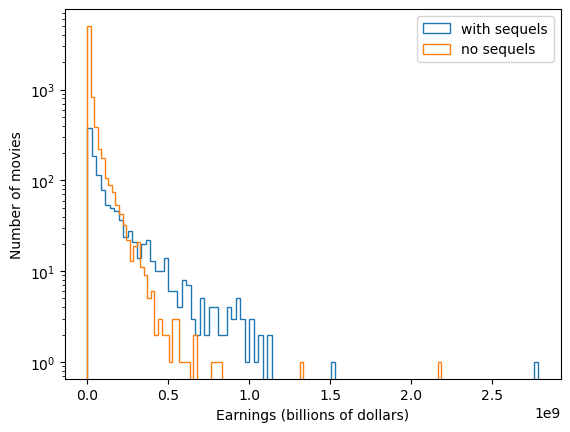

In [6]:
n_bins = 100
plt.hist(with_sequels_earnings['BoxOffice'], bins=n_bins, log=True, histtype="step",  label='with sequels')
plt.hist(no_sequels_earnings['BoxOffice'], bins=n_bins, log=True, histtype="step",  label='no sequels')
plt.xlabel('Earnings (billions of dollars)')
plt.ylabel('Number of movies')
plt.legend(loc='best')
plt.show()

At a quick look, it seems like movies with sequels rake in more money than those without. But hold on, a bunch of the data is missing!

In [7]:
print(f'percentage of movies with sequels that has the revenue in the dataset : {len(with_sequels_earnings)/ len(df_has_sequels):.2f}')
print(f'percentage of movies with no sequels that has the revenue in the dataset : {len(no_sequels_earnings)/ len(df_no_sequels):.2f}')

percentage of movies with sequels that has the revenue in the dataset : 0.31
percentage of movies with no sequels that has the revenue in the dataset : 0.09


Only 31% and 9% of the data repestively is present. We need a deeper analysis to confirm that movies with sequels are movies that tends generate more money.

### Duration 

In [8]:
with_sequels_duration = df_has_sequels.dropna(subset=['Runtime'])
no_sequels_duration = df_no_sequels.dropna(subset=['Runtime'])

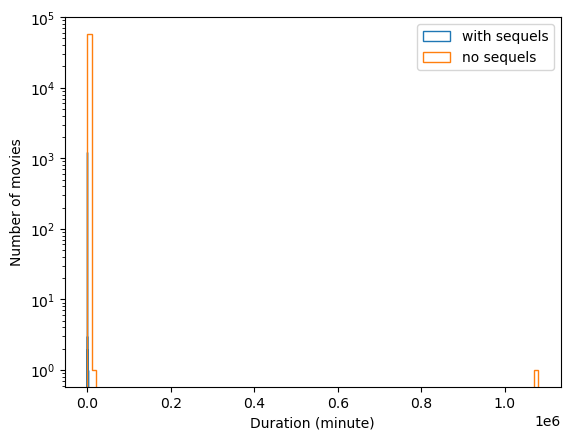

In [9]:
#Plot duration of movies with sequels and no sequels 
n_bins = 100
plt.hist(with_sequels_duration['Runtime'], bins=n_bins, log=True, histtype="step",  label='with sequels')
plt.hist(no_sequels_duration['Runtime'], bins=n_bins, log=True, histtype="step",  label='no sequels')
plt.xlabel('Duration (minute)')
plt.ylabel('Number of movies')
plt.legend(loc='best')
plt.show()

Even with a log-scale, we can't really see anything since we have that outlier. But who is that ? 

In [10]:
df_no_sequels[df_no_sequels['Runtime'] == df_no_sequels['Runtime'].max()]

,WikipediaID,FreebaseID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres
12804,10815585,/m/02qqy23,Zero Tolerance,1995,NaN,1079281.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F..."


A movie named **Zero Tolerance** but the [wikipedia page](https://en.wikipedia.org/wiki/Zero_Tolerance_(1994_film)), it is only 1h34m long. Weird but it is maybe a little bug when entering the numbers and since it is the only one, we filter it out. 

In [11]:
duration_outlier_id = df_no_sequels[df_no_sequels['Runtime'] == df_no_sequels['Runtime'].max()]['WikipediaID'].iloc[0]
no_sequels_duration = no_sequels_duration[no_sequels_duration['WikipediaID'] != duration_outlier_id]

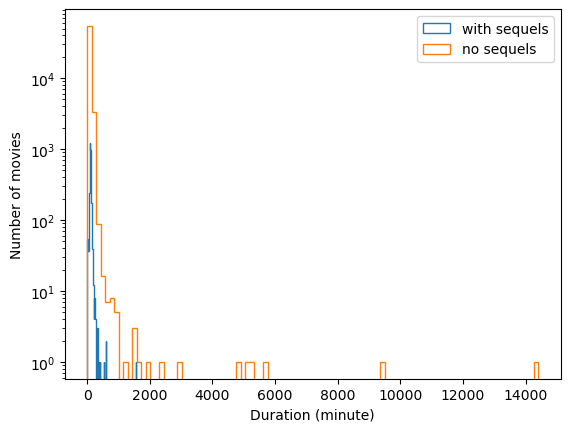

In [12]:
n_bins = 100
plt.hist(with_sequels_duration['Runtime'], bins=n_bins, log=True, histtype="step",  label='with sequels')
plt.hist(no_sequels_duration['Runtime'], bins=n_bins, log=True, histtype="step",  label='no sequels')
plt.xlabel('Duration (minute)')
plt.ylabel('Number of movies')
plt.legend(loc='best')
plt.show()

Now we have more outliers and we have to look into them. 

In [13]:
no_sequels_duration[no_sequels_duration['Runtime'] == no_sequels_duration['Runtime'].max()]

,WikipediaID,FreebaseID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres
62962,32441022,/m/0gyr803,Modern Times Forever,NaN,NaN,14400.0,{},{},"{""/m/0jtdp"": ""Documentary""}"


In our investigation of this movie, we came across this [wikipedia page](https://en.wikipedia.org/wiki/List_of_longest_films), specifically dedicated to the longest films. However, this category poses challenges for standard plotting. Additionally, it's worth noting that certain entries, like Swallow the Sun, may not fit the conventional definition of a movie, as it is a Korean drama spanning 25 episodes.

In [14]:
no_sequels_duration['Runtime'].describe()

count    57864.000000
mean        93.962255
std         93.392643
min          0.000000
25%         80.000000
50%         93.000000
75%        106.000000
max      14400.000000
Name: Runtime, dtype: float64

In [15]:
with_sequels_duration['Runtime'].describe()

count    3426.000000
mean       98.422834
std        42.194757
min         2.000000
25%        86.000000
50%        95.000000
75%       108.000000
max      1560.000000
Name: Runtime, dtype: float64

Runtime needs more analysis but using the describe funcion from pandas, we see that the 2 categories are quite close and we will continue the investigation if needed.

### Month of release

Some of the dates are just years, our initial task would be to extract the month from those that include a month.

In [85]:
df_has_sequels.loc[:,'Month'] = pd.to_datetime(df_has_sequels['ReleaseDate'], format='%Y-%m-%d', errors='coerce').dt.month
df_no_sequels.loc[:,'Month'] = pd.to_datetime(df_no_sequels['ReleaseDate'], format='%Y-%m-%d', errors='coerce').dt.month

with_sequels_months = df_has_sequels.dropna(subset=['Month'])
no_sequels_months = df_no_sequels.dropna(subset=['Month'])

In [93]:
count_months_sequels = with_sequels_months.groupby('Month')['Month'].sum()
count_months_no_sequels = no_sequels_months.groupby('Month')['Month'].sum()

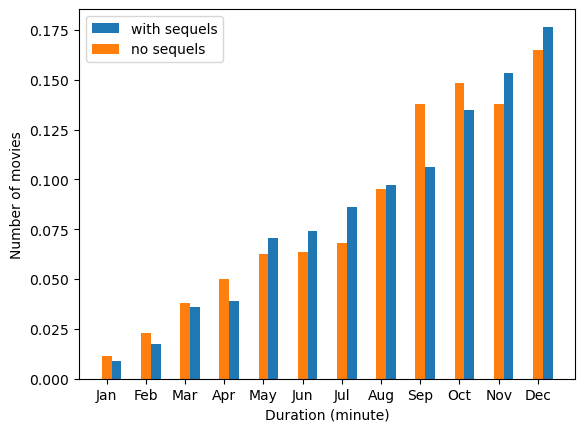

In [101]:
n_bins = 100
months = list(map(lambda x: calendar.month_abbr[x], np.arange(1,13)))
plt.bar(np.arange(1,13) + 0.25, count_months_sequels/count_months_sequels.sum(), 0.25, label='with sequels')
plt.bar(np.arange(1,13), count_months_no_sequels/count_months_no_sequels.sum(), 0.25, label='no sequels')
plt.xticks(np.arange(1,13), months)
plt.xlabel('Duration (minute)')
plt.ylabel('Number of movies')
plt.legend(loc='best')
plt.show()

### Year of release

In [104]:
df_has_sequels.loc[:,'Year'] = pd.to_datetime(df_has_sequels['ReleaseDate'], format='%Y-%m-%d', errors='coerce').dt.year
df_no_sequels.loc[:,'Year'] = pd.to_datetime(df_no_sequels['ReleaseDate'], format='%Y-%m-%d', errors='coerce').dt.year

with_sequels_year = df_has_sequels.dropna(subset=['Year'])
no_sequels_year = df_no_sequels.dropna(subset=['Year'])

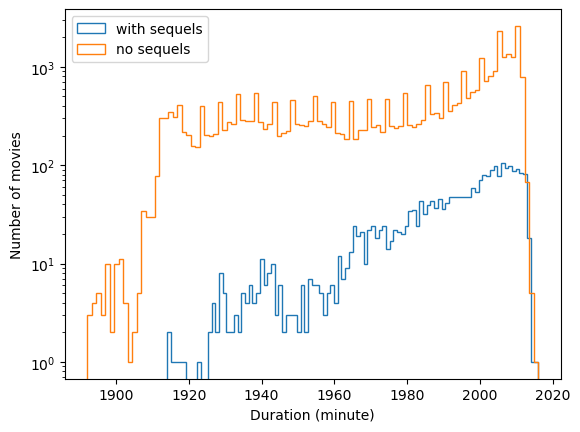

In [113]:
n_bins = 100
plt.hist(with_sequels_year['Year'], bins=n_bins, log=True, histtype="step",  label='with sequels')
plt.hist(no_sequels_year['Year'], bins=n_bins, log=True, histtype="step",  label='no sequels')
plt.xlabel('Duration (minute)')
plt.ylabel('Number of movies')
plt.legend(loc='best')
plt.show()

In [114]:
# TODO: plot percentage of sequel per year and see if it is an increasing trend